In [1]:
pip install pyntcloud

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 346.3/346.3 kB 8.7 MB/s eta 0:00:0000:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import cv2
from pyntcloud import PyntCloud
import matplotlib.pyplot as plt
%matplotlib inline



pattern_size = (9, 6)
square_size = 0.108  

all_images_names = []
camera_parameters_name = []
lidar_scans_names = []
import os
all_frame_names = []
for dirname, _, filenames in os.walk('/kaggle/input/lidar-dataset/camera_images'):
    for filename in filenames:
        all_images_names.append(os.path.join(dirname, filename))
        all_frame_names.append(filename[:-5])
        
for dirname, _, filenames in os.walk('/kaggle/input/lidar-dataset/camera_images'):
    for filename in filenames:
        camera_parameters_name.append(os.path.join("/kaggle/input/lidar-dataset/camera_parameters", filename))

for dirname, _, filenames in os.walk('/kaggle/input/lidar-dataset/lidar_scans'):
    for filename in filenames:
        lidar_scans_names.append(os.path.join(dirname, filename))
        

In [3]:
import numpy as np
normals = []
offsets = []
# Load PCD file into a NumPy array

for lidar_scan in all_frame_names:
    cloud = PyntCloud.from_file(f"/kaggle/input/lidar-dataset/lidar_scans/{lidar_scan}.pcd")
#     print(lidar_scan)
    pcd = np.array(cloud.points[["x", "y", "z"]])
    pcd = pcd - cloud.centroid
    
    u, sigma, v_t = np.linalg.svd(pcd.T @ pcd, full_matrices = False)
    normal = u[:, 2]

    offset = np.dot(normal, cloud.centroid)
    if offset < 0:
        offset = -offset
        normal = -normal
        
    
    normals.append(normal.reshape(3))
    offsets.append(offset)
        
    print("Chessboard plane normal vector:", normal)
    print("Chessboard plane offset:", offset)

Chessboard plane normal vector: [ 0.93223065 -0.19842705 -0.3026098 ]
Chessboard plane offset: 6.265358
Chessboard plane normal vector: [ 0.9328821  -0.24403861  0.26490793]
Chessboard plane offset: 5.6742587
Chessboard plane normal vector: [ 0.87718356 -0.41582555  0.24007946]
Chessboard plane offset: 7.435547
Chessboard plane normal vector: [ 0.76477665 -0.64422625 -0.0094462 ]
Chessboard plane offset: 6.9878364
Chessboard plane normal vector: [0.9415104  0.18949716 0.27865583]
Chessboard plane offset: 6.323572
Chessboard plane normal vector: [ 0.8187873  0.5076373 -0.2681264]
Chessboard plane offset: 6.4454384
Chessboard plane normal vector: [ 0.4734635  -0.75992006 -0.44536924]
Chessboard plane offset: 5.2549844
Chessboard plane normal vector: [ 0.60407287 -0.774129    0.18926245]
Chessboard plane offset: 5.0623527
Chessboard plane normal vector: [ 0.6187274  -0.7829378   0.06469016]
Chessboard plane offset: 6.589564
Chessboard plane normal vector: [ 0.40409026 -0.88184714  0.24301

In [30]:
np.mean(offsets)

6.505493

In [4]:
#lets load camera normals
index = 0
alpha_c = []
theta_c = []
alpha_l = []
theta_l = []
for camera in all_frame_names: 
    t = np.array(np.loadtxt(f"/kaggle/input/lidar-dataset/camera_parameters/{camera}.jpeg/translation_vectors.txt"))
    normal_camera = np.array(np.loadtxt(f"/kaggle/input/lidar-dataset/camera_parameters/{camera}.jpeg/camera_normals.txt"), dtype = np.float32)
    

    t = np.array([[t[0], t[1], t[2]]])
    current_theta_c = np.array([[normal_camera[0], normal_camera[1], normal_camera[2]]])
    current_theta_l = normals[index]
    current_alpha_l = offsets[index]
    current_alpha_c = t @ current_theta_c.T
    if(current_alpha_c < 0):
        current_alpha_c *=-1
        current_theta_c*=-1
    index+=1
    
    alpha_c.append(current_alpha_c)
    theta_c.append(current_theta_c)
    alpha_l.append(current_alpha_l)
    theta_l.append(current_theta_l)

alpha_c = np.array(alpha_c)
alpha_l = np.array(alpha_l)
theta_l = np.array(theta_l)
theta_c = np.array(theta_c)


theta_c = np.squeeze(theta_c)
alpha_c = np.squeeze(alpha_c)

print("The shape of normals is: ", theta_l.shape, theta_c.shape)
print("The shape of offset is: ", alpha_l.shape, alpha_c.shape)
#Now we will get the "R"
# print(lidar_alphas.shape, camera_alphas.shape)
A = theta_l.T @ theta_c
u, sigma, v_t = np.linalg.svd(A)
R_1 = v_t.T @ u.T

print(f"Determinant of matrix: {np.linalg.det(R_1)}")
    

#Now we will calculate "T"
inv = np.linalg.inv(theta_c.T @ theta_c)
T_1 = inv @ theta_c.T @ (alpha_c - alpha_l)
print("The value of T_1 is", T_1)
print("The value of R_1 is", R_1)

The shape of normals is:  (38, 3) (38, 3)
The shape of offset is:  (38,) (38,)
Determinant of matrix: 1.0
The value of T_1 is [ 0.08855644 -0.36208099 -0.5992567 ]
The value of R_1 is [[-1.7515889e-01 -9.8454016e-01  1.3609635e-04]
 [ 1.5356026e-02 -2.8701860e-03 -9.9987799e-01]
 [ 9.8442042e-01 -1.7513540e-01  1.5621364e-02]]


In [5]:
print(np.mean(alpha_l), np.mean(alpha_c))

6.505493 5.995314255323265


In [6]:
cTl = np.zeros((4,4))

cTl[:3,:3] = R_1
cTl[:3,3] = T_1
cTl[3][3] = 1

print("The estimated tranformation matrix is: \n",cTl)

The estimated tranformation matrix is: 
 [[-1.75158888e-01 -9.84540164e-01  1.36096351e-04  8.85564404e-02]
 [ 1.53560257e-02 -2.87018600e-03 -9.99877989e-01 -3.62080989e-01]
 [ 9.84420419e-01 -1.75135404e-01  1.56213641e-02 -5.99256704e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [7]:
K = np.array(np.loadtxt("/kaggle/input/lidar-dataset/camera_parameters/camera_intrinsic.txt"))
camera_intrinsic = np.zeros((3,4))
camera_intrinsic[:3,:3] = K
projection = []
for lidar_scan in all_frame_names:
    cloud = PyntCloud.from_file(f"/kaggle/input/lidar-dataset/lidar_scans/{lidar_scan}.pcd")
    pcd = np.array(cloud.points[["x", "y", "z"]])
    img = cv2.imread(f"/kaggle/input/lidar-dataset/camera_images/{lidar_scan}.jpeg")
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (8, 6), None)
    
    points = np.ones((pcd.shape[0], pcd.shape[1]+1))
    points[:points.shape[0],:3] = pcd
    camera_points = (camera_intrinsic @ cTl @ points.T).T
    
#     print(camera_points.shape)
    
    homogenous = []
    for current_point in camera_points:
#         print(current_point.shape)
        homogenous.append((current_point / current_point[2])[:2])
#     print(cTl.shape, camera_intrinsic.shape, points.T.shape)
    if(ret):
        projection.append(homogenous)
    
# projection = np.array(projection)
# print(projection.shape)    

frame_595


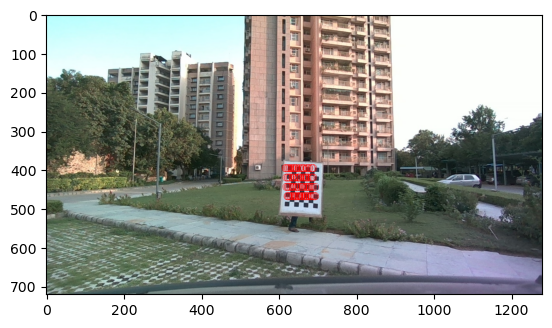

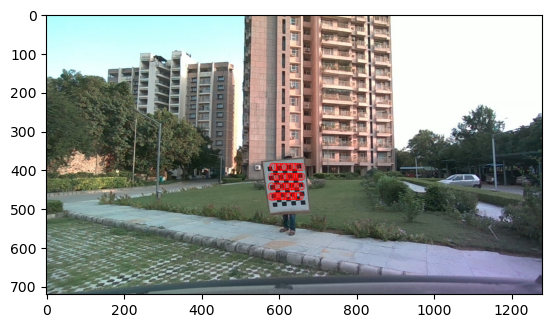

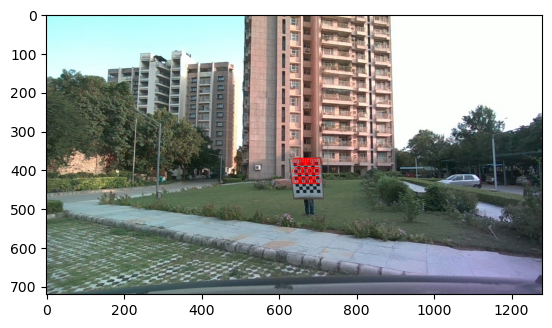

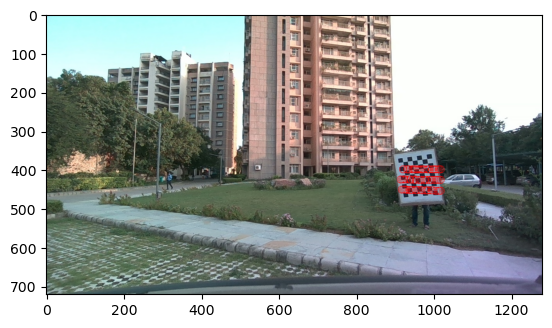

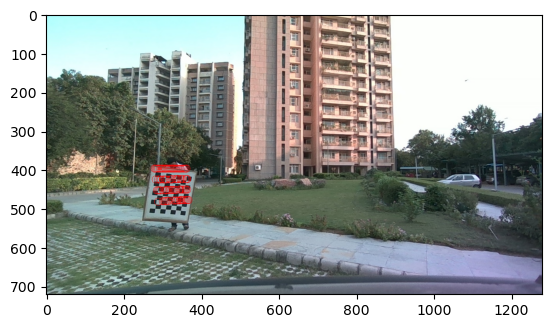

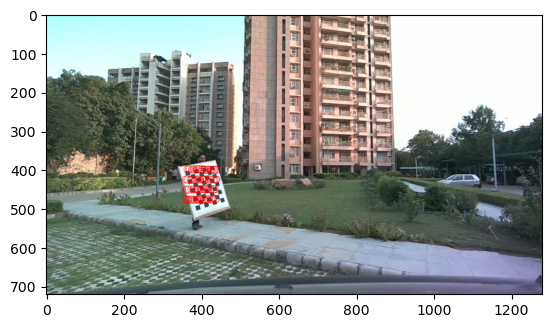

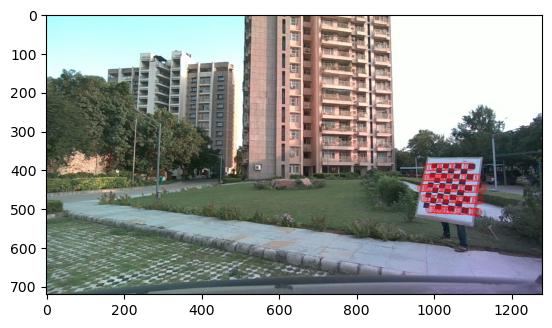

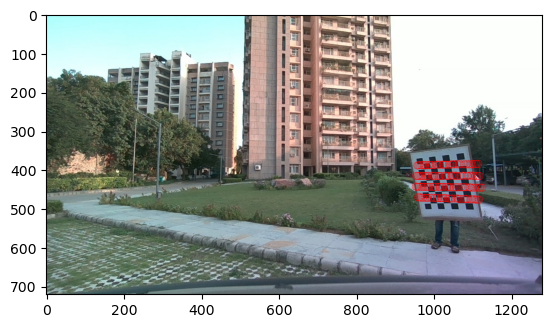

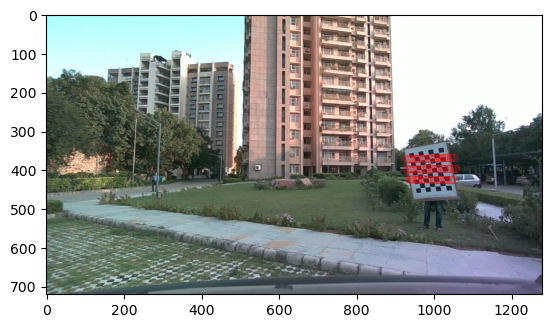

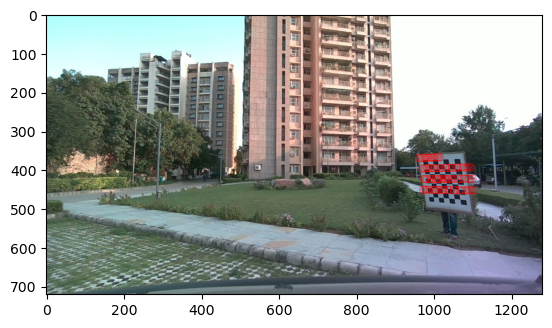

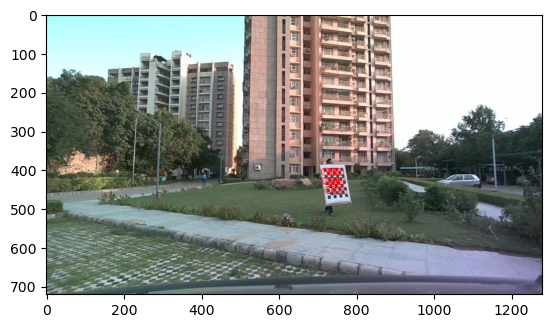

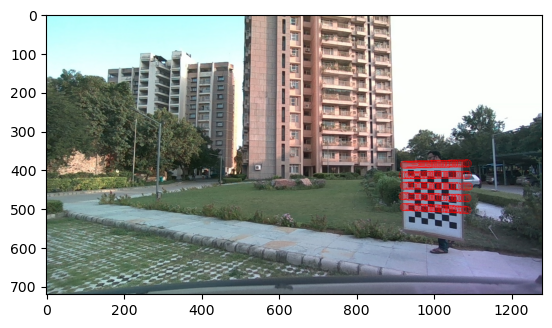

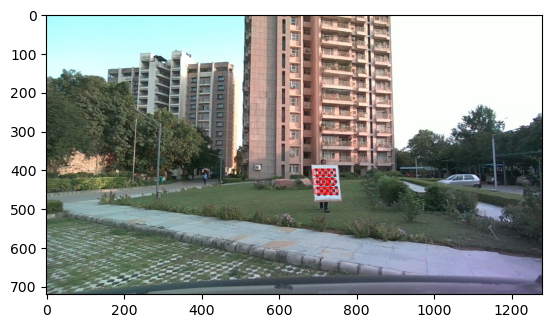

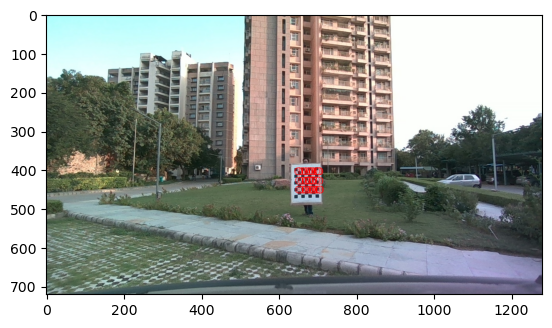

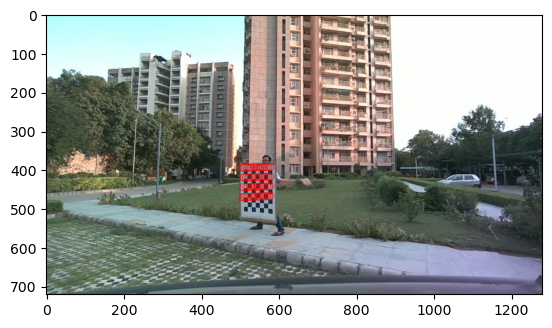

In [8]:
index = 0
# lidar_frame = [f"/kaggle/input/lidar-dataset/lidar_scans/{all_frame_names[0]}.pcd"]
print(all_frame_names[0])
for lidar_scan in all_frame_names:
    if(index == 15): break
    img = cv2.imread(f"/kaggle/input/lidar-dataset/camera_images/{lidar_scan}.jpeg")
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ret, corners =cv2.findChessboardCorners(gray, (8, 6), None)
    if(ret == True):
        points = projection[index]
        index+=1
#         print(len(points), len(points[0]))
        
        for p in points:
#             if(p[0] < 0 or p[1] < 0): continue
#             print(p[0], p[1])
            cv2.circle(gray, (int(p[0]), int(p[1])), 10, (255, 0, 0), 1)
    
    plt.imshow(gray)
    plt.show()
    

(3, 38)


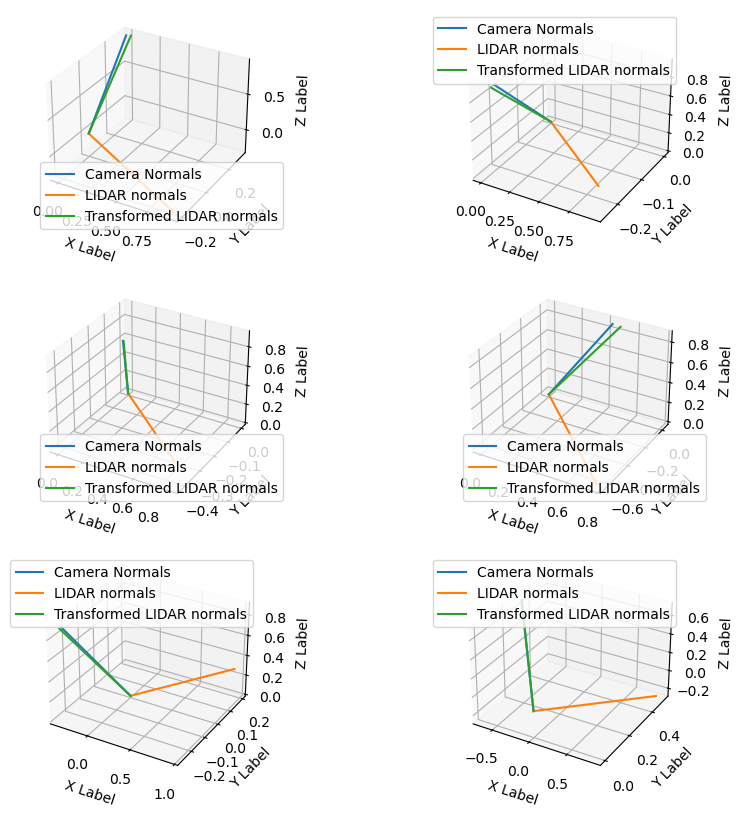

In [9]:
fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(3, 2, 1, projection='3d')
ax2 = fig.add_subplot(3, 2, 2, projection='3d')
ax3 = fig.add_subplot(3, 2, 3, projection='3d')
ax4 = fig.add_subplot(3, 2, 4, projection='3d')
ax5 = fig.add_subplot(3, 2, 5, projection='3d')
ax6 = fig.add_subplot(3, 2, 6, projection='3d')
ax = [ax1, ax2, ax3, ax4, ax5, ax6]

normals_rotated_lidar = R_1 @ theta_l.T
print(normals_rotated_lidar.shape)


# Plot the data
for i in range(6):
    
    ax[i].plot([0,theta_c.T[0][i]], [0,theta_c.T[1][i]], [0,theta_c.T[2][i]])
    ax[i].plot([0,theta_l.T[0][i]], [0,theta_l.T[1][i]], [0,theta_l.T[2][i]])
    ax[i].plot([0,normals_rotated_lidar[0][i]], [0,normals_rotated_lidar[1][i]], [0,normals_rotated_lidar[2][i]])

    # Set the axis labels
    ax[i].set_xlabel('X Label')
    ax[i].set_ylabel('Y Label')
    ax[i].set_zlabel('Z Label')

    ax[i].legend(['Camera Normals', 'LIDAR normals', 'Transformed LIDAR normals'])

    # Show the plot
plt.show()

In [37]:
error = []
one_minus_error = []
for i in range(35):
    error.append(theta_c[0] @ normals_rotated_lidar.T[0])
    one_minus_error.append(error[i])
    error[i] = 1-error[i]
print(error)

[0.0005412101745605469, 0.0005412101745605469, 0.0005412101745605469, 0.0005412101745605469, 0.0005412101745605469, 0.0005412101745605469, 0.0005412101745605469, 0.0005412101745605469, 0.0005412101745605469, 0.0005412101745605469, 0.0005412101745605469, 0.0005412101745605469, 0.0005412101745605469, 0.0005412101745605469, 0.0005412101745605469, 0.0005412101745605469, 0.0005412101745605469, 0.0005412101745605469, 0.0005412101745605469, 0.0005412101745605469, 0.0005412101745605469, 0.0005412101745605469, 0.0005412101745605469, 0.0005412101745605469, 0.0005412101745605469, 0.0005412101745605469, 0.0005412101745605469, 0.0005412101745605469, 0.0005412101745605469, 0.0005412101745605469, 0.0005412101745605469, 0.0005412101745605469, 0.0005412101745605469, 0.0005412101745605469, 0.0005412101745605469]


(array([ 0.,  0.,  0.,  0.,  0., 35.,  0.,  0.,  0.,  0.]),
 array([-0.49945879, -0.39945879, -0.29945879, -0.19945879, -0.09945879,
         0.00054121,  0.10054121,  0.20054121,  0.30054121,  0.40054121,
         0.50054121]),
 <BarContainer object of 10 artists>)

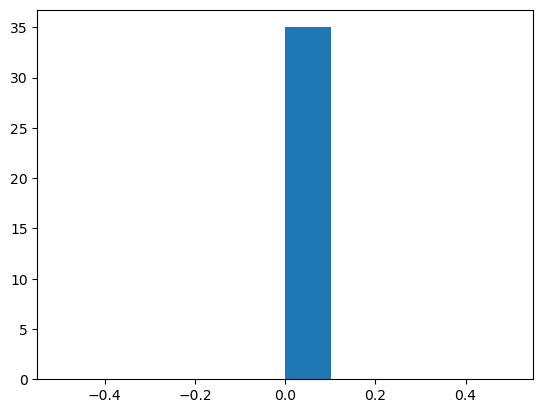

In [38]:
plt.hist(error)

In [44]:
np.std(error)

0.0